In [1]:
%matplotlib widget

In [2]:
from pathlib import Path
#from dataclasses import dataclass

import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from tqdm import tqdm

from pyinverse.angle import Angle
from pyinverse.axis import RegularAxis
from pyinverse.grid import RegularGrid
from pyinverse.axes import RegularAxes3
from pyinverse.phantom3 import Phantom3
from pyinverse.ray3 import ray_matrix
from pyinverse.fbp3 import fbp3_theta0

from pyrsss.signal.dgrad import GradientFilter

In [3]:
CALCULATE_MATRICES = False
CACHE_PATH = Path('./radon')

In [4]:
Nx = 255 // 2
Ny = 256 // 2
Nz = 257 // 2
axes3 = RegularAxes3.linspace((-1, 1, Nx), (-1, 1, Ny), (-1, 1, Nz))

In [5]:
Nu = 512 // 2
Nv = 513 // 2

grid_uv = RegularGrid.linspace((-2, 2, Nu), (-2, 2, Nv))

In [6]:
# trivial geometry (via Clack 1992) is with theta = 0
theta = Angle(deg=0)

N_phi = 256 // 2
phi_deg_axis = RegularAxis.linspace(0, 180, N_phi, endpoint=False)
phi = [Angle(deg=x) for x in phi_deg_axis]

In [7]:
p3 = Phantom3()
x3 = p3.raster(axes3)

In [8]:
p_uv = p3.proj(theta, phi[0], grid_uv)

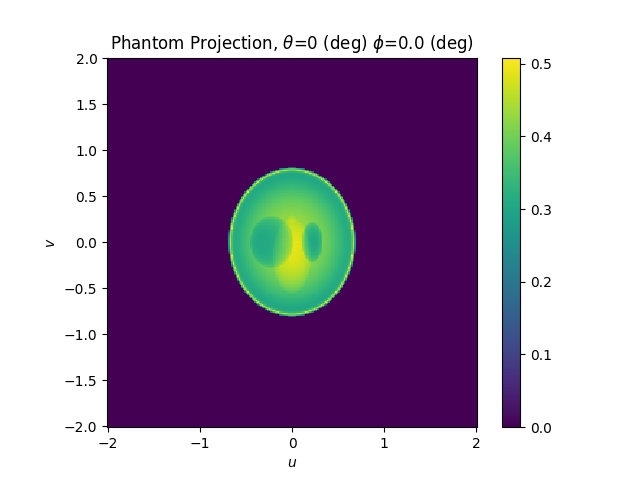

In [9]:
fig, ax = plt.subplots()
im = grid_uv.plot(ax, p_uv)
ax.set_xlabel(f'$u$')
ax.set_ylabel(f'$v$')
ax.set_title(f'Phantom Projection, $\\theta$={theta.deg} (deg) $\phi$={phi[0].deg} (deg)')
plt.colorbar(im, ax=ax);

In [10]:
if CALCULATE_MATRICES:
    for i, phi_i in tqdm(enumerate(phi), total=N_phi, leave=None):
        A_i = ray_matrix(theta, phi_i, axes3, grid_uv)
        npz_path = CACHE_PATH / f'A_{i}_{Nx}_{Ny}_{Nz}_{Nu}_{Nv}.npz'
        sp.sparse.save_npz(npz_path, A_i)
else:
    #assert False
    pass

In [11]:
x3_proj = []
for i, phi_i in tqdm(enumerate(phi), total=N_phi):
    x3_proj.append(p3.proj(theta, phi_i, grid_uv))

100%|█████████████████████████████████████████████████████████████| 128/128 [00:03<00:00, 40.73it/s]


VMAX = 0.51

OUTPUT_PATH = Path('/tmp/test')

DPI = 300

fig, ax = plt.subplots(ncols=2, figsize=(11, 4))
for i, (phi_i, x3_proj_i) in tqdm(enumerate(zip(phi, x3_proj)), total=N_phi):
    im = grid_uv.plot(ax[0], x3_proj_i, vmin=0, vmax=VMAX)
    ax[0].set_xlabel(f'$u$')
    ax[0].set_ylabel(f'$v$')
    ax[0].set_title(f'Phantom Projection, $\\theta$={theta.deg} (deg) $\phi$={phi_i.deg:.1f} (deg)')
    if i == 0:
        plt.colorbar(im, ax=ax[0])

    npz_path = CACHE_PATH / f'A_{i}_{Nx}_{Ny}_{Nz}_{Nu}_{Nv}.npz'
    A_i = sp.sparse.load_npz(npz_path)

    x_proj_A = A_i @ x3.flat
    x_proj_A.shape = grid_uv.shape

    im = grid_uv.plot(ax[1], x_proj_A, vmin=0, vmax=VMAX)
    ax[1].set_xlabel(f'$u$')
    ax[1].set_ylabel(f'$v$')
    ax[1].set_title('Projection via Radon Matrix')
    if i == 0:
        plt.colorbar(im, ax=ax[1])
    
    fig.savefig(OUTPUT_PATH / f'{i:05}.png', dpi=DPI)

# ffmpeg -r 10 -i %05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4

In [12]:
x3_hat_backproject3 = fbp3_theta0(axes3, grid_uv, phi_deg_axis, x3_proj)

  0%|          | 0/128 [00:00<?, ?it/s]

In [13]:
class RadonMatrices:
    def __init__(self, Nx, Ny, Nz, Nu, Nv, CACHE_PATH=CACHE_PATH):
        self.Nx = Nx
        self.Ny = Ny
        self.Nz = Nz
        self.Nu = Nu
        self.Nv = Nv
        self.CACHE_PATH = CACHE_PATH
        self._d = {}
    
    def __getitem__(self, i):
        npz_path = self.CACHE_PATH / f'A_{i}_{self.Nx}_{self.Ny}_{self.Nz}_{self.Nu}_{self.Nv}.npz'
        if npz_path in self._d:
            return self._d[npz_path]
        else:
            self._d[npz_path] = sp.sparse.load_npz(npz_path)
            return self._d[npz_path]

In [14]:
x3_hat_radon = fbp3_theta0(axes3, grid_uv, phi_deg_axis, x3_proj, radon_matrices=RadonMatrices(Nx, Ny, Nz, Nu, Nv))

  0%|          | 0/128 [00:00<?, ?it/s]

In [15]:
k_mid = Nz // 2

In [16]:
grid_xy = RegularGrid(axes3.axis_x, axes3.axis_y)

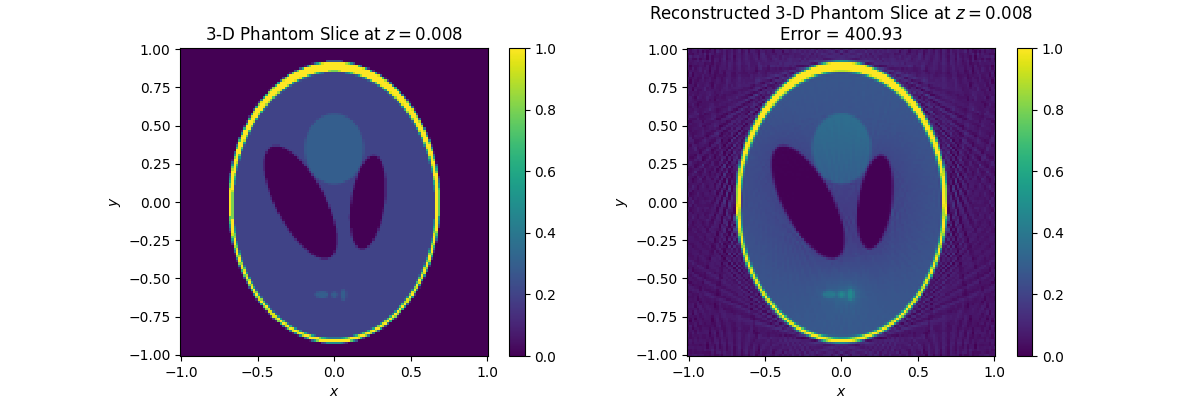

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
im0 = grid_xy.plot(ax[0], x3[k_mid, :, :], vmin=0, vmax=1)
ax[0].set_xlabel(f'$x$')
ax[0].set_ylabel(f'$y$')
ax[0].set_title(f'3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_xy.plot(ax[1], x3_hat_backproject3[k_mid, :, :], vmin=0, vmax=1)
ax[1].set_xlabel(f'$x$')
ax[1].set_ylabel(f'$y$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}\nError = {np.linalg.norm((x3 - x3_hat_backproject3).flat):.2f}')
plt.colorbar(im1, ax=ax[1]);

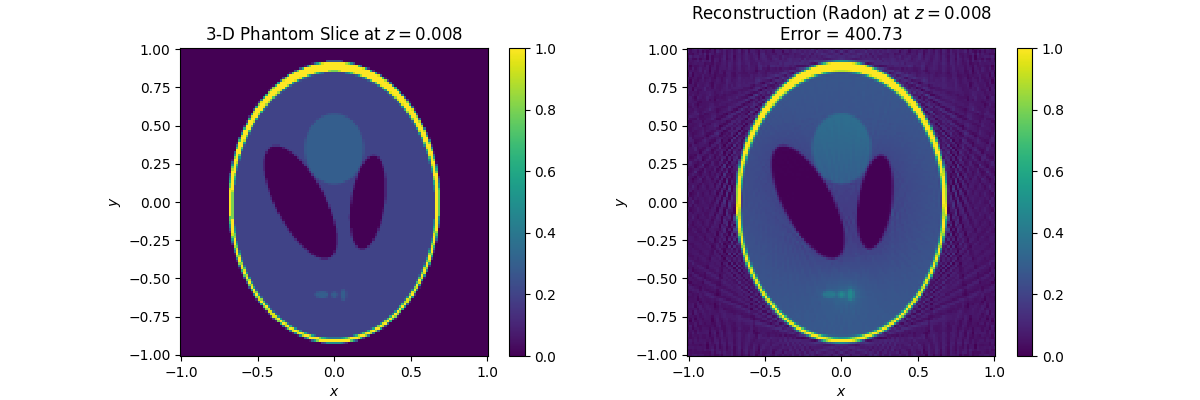

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
im0 = grid_xy.plot(ax[0], x3[k_mid, :, :], vmin=0, vmax=1)
ax[0].set_xlabel(f'$x$')
ax[0].set_ylabel(f'$y$')
ax[0].set_title(f'3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_xy.plot(ax[1], x3_hat_radon[k_mid, :, :], vmin=0, vmax=1)
ax[1].set_xlabel(f'$x$')
ax[1].set_ylabel(f'$y$')
ax[1].set_title(f'Reconstruction (Radon) at $z=${axes3.axis_z[k_mid]:.3f}\nError = {np.linalg.norm((x3 - x3_hat_radon).flat):.2f}')
plt.colorbar(im1, ax=ax[1]);

In [19]:
class D_matrix:
    def __init__(self, axes3):
        self.axes3 = axes3
        self.Dx = GradientFilter(axes3.shape, 0)
        self.Dy = GradientFilter(axes3.shape, 1)
        self.Dz = GradientFilter(axes3.shape, 2)

    def __matmul__(self, x):
        z_x = self.Dx @ x
        z_y = self.Dy @ x
        z_z = self.Dz @ x
        return np.hstack((z_x, z_y, z_z))

    def asmatrix(self):
        try:
            return self._matrix
        except AttributeError:
            self._matrix = sp.sparse.vstack([x.asmatrix() for x in [self.Dx, self.Dy, self.Dz]])
            return self.asmatrix()

In [20]:
def tikhonov(x, axes, radon_matrices, y, I, D, lambda_tik, term='both'):
    cost = 0
    if term in {'data', 'both'}:
        for i in range(I):
            A_i = radon_matrices[i]
            z = y[i] - A_i @ x
            cost += np.dot(z, z)
    if term in {'tik', 'both'}:
        x_reshape = np.reshape(x, axes.shape)
        z_D = D @ x_reshape
        cost += lambda_tik * np.dot(z_D, z_D)
    return cost

In [21]:
"""
A: M x N
D: L X N

A^T * A: N x N
D^T * D: N x N

cost = ||y - Ax||^2 + l ||Dx||^2
     = (y - A*x)^T * (y - A*x) + l (D*x)^T * (D*x)
     = x^T * A^T * A * x - 2 * y^T * A * x + y^T * y + l * x^T * D^T * D * x
     = z^T * z - 2 * y^t * z + y^t * y + l & w^T * w

where z = A * x and w = D * x.
     
grad_x cost = 2 * A^T * A * x - 2 * y^T * A + 2 * l * D^T * D * x
            = 2 * A^T * z - 2 * y^T * A + 2 * l & D^T * w

Hessian_x cost = 2 * A^T * A + 2 * l * D^T * D
""";

In [22]:
def grad(x, axes, radon_matrices, y, I, D, lambda_tik, term='both'):
    cost = 0
    if term in {'data', 'both'}:
        for i, y_i in enumerate(y):
            A_i = radon_matrices[i]
            cost += 2 * (A_i.T @ (A_i @ x))
            cost -= 2 * (y_i @ A_i)
    if term in {'tik', 'both'}:
        x_reshape = np.reshape(x, axes.shape)
        w = D @ x_reshape
        cost += 2 * lambda_tik * (D.asmatrix().T @ w)
    return cost

In [23]:
x0 = np.array(x3_hat_radon.flat)

In [24]:
y = [x.flat for x in x3_proj]

In [25]:
radon_matrices = RadonMatrices(Nx, Ny, Nz, Nu, Nv)

In [26]:
D = D_matrix(axes3)

In [27]:
lambda_tik = 1e-2

In [28]:
bounds = [(0, None) for _ in range(len(x0))]

In [29]:
NIT = 0

def callback(intermediate_result):
    global NIT
    x = intermediate_result.x
    cost = intermediate_result.fun
    NIT += 1
    cost_tik = tikhonov(x, axes3, radon_matrices, y, N_phi, D, lambda_tik, term='tik')
    cost_data = cost - cost_tik
    print(f'{NIT}: cost={cost} cost_data={cost_tik} cost_tik={cost_data}')
    #np.save(f'./radon/x_hat_{NIT:04d}.npy', x)

In [30]:
args = (axes3, radon_matrices, y, N_phi, D, lambda_tik)
NIT = 0
res = sp.optimize.minimize(tikhonov, x0, args, jac=grad, bounds=bounds, callback=callback) 

1: cost=68011.24586915177 cost_data=1193.7784120705637 cost_tik=66817.4674570812
2: cost=3362.67285503599 cost_data=464.34027263104366 cost_tik=2898.332582404946
3: cost=2269.162431391236 cost_data=438.9733575907921 cost_tik=1830.189073800444
4: cost=1065.1261126800948 cost_data=383.85862936716063 cost_tik=681.2674833129342
5: cost=869.034478752341 cost_data=361.4323396985043 cost_tik=507.6021390538367
6: cost=750.5345870378869 cost_data=351.11985800732367 cost_tik=399.41472903056325
7: cost=680.7100102401855 cost_data=344.9433871644786 cost_tik=335.7666230757069
8: cost=631.3908095777814 cost_data=340.1865003390861 cost_tik=291.2043092386953
9: cost=618.4503692242492 cost_data=335.240872749954 cost_tik=283.20949647429524
10: cost=603.7157666708927 cost_data=334.15872964318646 cost_tik=269.5570370277062
11: cost=599.0964833042353 cost_data=332.88529699091515 cost_tik=266.2111863133202
12: cost=594.7953246677125 cost_data=331.25809702557854 cost_tik=263.537227642134
13: cost=590.0971532

In [31]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 586.4208803195919
        x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
      nit: 40
      jac: [ 1.255e-18  3.150e-18 ...  1.023e-18  2.103e-18]
     nfev: 46
     njev: 46
 hess_inv: <2080768x2080768 LbfgsInvHessProduct with dtype=float64>

In [32]:
x3_hat_minimize = res.x
x3_hat_minimize.shape = axes3.shape

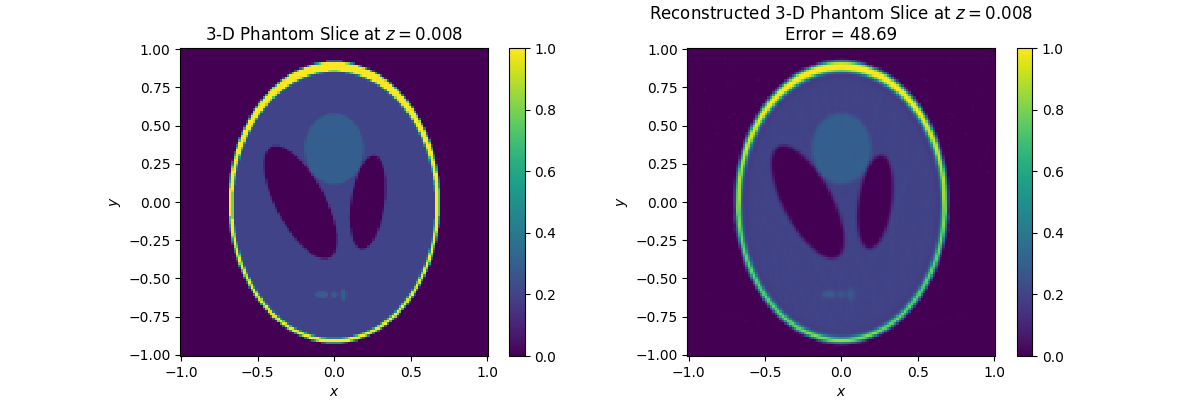

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
im0 = grid_xy.plot(ax[0], x3[k_mid, :, :], vmin=0, vmax=1)
ax[0].set_xlabel(f'$x$')
ax[0].set_ylabel(f'$y$')
ax[0].set_title(f'3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_xy.plot(ax[1], x3_hat_minimize[k_mid, :, :], vmin=0, vmax=1)
ax[1].set_xlabel(f'$x$')
ax[1].set_ylabel(f'$y$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}\nError = {np.linalg.norm((x3 - x3_hat_minimize).flat):.2f}')
plt.colorbar(im1, ax=ax[1]);

In [35]:
NIT = 0
res0 = sp.optimize.minimize(tikhonov, np.zeros_like(x0), args, jac=grad, bounds=bounds, callback=callback) 

1: cost=80526.45835552637 cost_data=0.02312085732185485 cost_tik=80526.43523466904
2: cost=9957.746940940418 cost_data=2.7843452706275698 cost_tik=9954.962595669791
3: cost=7437.194340274587 cost_data=5.157907598272509 cost_tik=7432.036432676315
4: cost=2469.111609785683 cost_data=33.9258171354406 cost_tik=2435.1857926502425
5: cost=1669.8868928663671 cost_data=61.337391129220975 cost_tik=1608.549501737146
6: cost=1115.4201868948048 cost_data=125.57765640287329 cost_tik=989.8425304919315
7: cost=879.5346567101262 cost_data=157.54848123417025 cost_tik=721.986175475956
8: cost=776.7325409922776 cost_data=182.01886676485253 cost_tik=594.713674227425
9: cost=679.9308122951115 cost_data=228.04869719142218 cost_tik=451.88211510368933
10: cost=645.4882022963532 cost_data=273.2776058491888 cost_tik=372.2105964471644
11: cost=620.076584030567 cost_data=280.90241382463995 cost_tik=339.17417020592706
12: cost=609.5665257989044 cost_data=288.4830671912577 cost_tik=321.0834586076467
13: cost=600.39

In [36]:
x3_hat_minimize0 = res0.x
x3_hat_minimize0.shape = axes3.shape

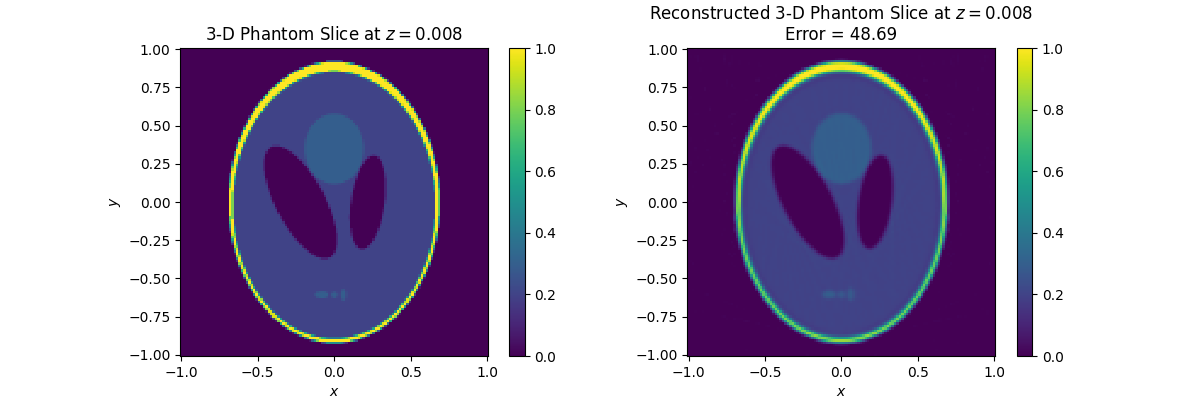

In [37]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
im0 = grid_xy.plot(ax[0], x3[k_mid, :, :], vmin=0, vmax=1)
ax[0].set_xlabel(f'$x$')
ax[0].set_ylabel(f'$y$')
ax[0].set_title(f'3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_xy.plot(ax[1], x3_hat_minimize0[k_mid, :, :], vmin=0, vmax=1)
ax[1].set_xlabel(f'$x$')
ax[1].set_ylabel(f'$y$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}\nError = {np.linalg.norm((x3 - x3_hat_minimize0).flat):.2f}')
plt.colorbar(im1, ax=ax[1]);